## Reading the midi File and finding the chords

In [1]:
import music21 as ms

In [3]:
mfile = ms.converter.parse('boss.mid')

ConverterException: File not found or no such format found for: boss.mid

In [3]:
mChords = mfile.chordify()

In [4]:
chordList = []
chordVectors = []
for c in mChords.recurse().getElementsByClass('Chord'):
    chordList.append(c.orderedPitchClasses)
    chordVectors.append(c.intervalVector)

In [5]:
def Connected(l1, x, y, z):
    j = 0
    for i in l1:
        if (
           sum(i) - 2*(i[x] + i[y] + i[z]) < 0 
        ):
            j += 1
    return j

In [6]:
TonnetzConnectivity = {
    'T129' : Connected(chordVectors, 0, 1 ,2),
    'T138' : Connected(chordVectors, 0, 2 ,3),
    'T147' : Connected(chordVectors, 0, 3 ,4),
    'T156' : Connected(chordVectors, 0, 4 ,5),
    'T237' : Connected(chordVectors, 1, 2 ,4),
    'T246' : Connected(chordVectors, 1, 3 ,5),
    'T345' : Connected(chordVectors, 2, 3 ,4)
}

In [7]:
GetTheBestTonnetz = max(TonnetzConnectivity, key=TonnetzConnectivity.get)  # Just use 'min' instead of 'max' for minimum.
print(GetTheBestTonnetz, TonnetzConnectivity[GetTheBestTonnetz])

T345 14


In [8]:
if GetTheBestTonnetz == 'T129' :
    Tonnetz = [1, 2, 9]
elif GetTheBestTonnetz == 'T138' :
    Tonnetz = [1, 3, 8]
elif GetTheBestTonnetz == 'T147' :
    Tonnetz = [1, 4, 7]
elif GetTheBestTonnetz == 'T156' :
    Tonnetz = [2, 5, 6]
elif GetTheBestTonnetz == 'T237' :
    Tonnetz = [2, 3, 7]
elif GetTheBestTonnetz == 'T246' :
    Tonnetz = [2, 4, 6]
elif GetTheBestTonnetz == 'T345' :
    Tonnetz = [3, 4, 5]
    

In [9]:
def removeNonConnected(l1, l2, T_axes):
    axe1 = T_axes[0] - 1
    axe2 = T_axes[1] - 1
    if T_axes[2] > 6:
        axe3 = (12 - T_axes[2]) - 1
    else : 
        axe3 = T_axes[2] - 1
    nl1 = l1
    nl2 = []
    j = 0
    for i in l2:
        if (
           sum(i) - 2*(i[axe1] + i[axe2] + i[axe3]) < 0 
        ):
            nl2.append(i)
            j += 1
        else :
            del nl1[j]            
    return nl1, nl2

In [10]:
chordListConnect, vectorsListConnect = removeNonConnected(chordList, chordVectors, Tonnetz)

In [11]:
import ast
def removeDoubles(l):
    N = len(l)
    nl = []
    sl = [str(i) for i in l]
    nl.append(l[0])
    for i in range(1,N):
        if sl[i] != sl[i-1]:
           nl.append(ast.literal_eval(sl[i]))
    return nl

In [12]:
chordListConnectNoDoubles = removeDoubles(chordListConnect)

In [13]:
len(chordList), len(chordListConnect), len(chordListConnectNoDoubles) 

(14, 14, 14)

## Trajectory Calculations

In [14]:
def intervalToPoint(num, axes, T_axes):
    axe1 = T_axes[0]
    axe2 = T_axes[1]
    axe3 = T_axes[2]
    point = (0, 0)
    if num == 0:
        point = (axes[0], axes[1])
    elif num == axe1:
        point = (axes[0], axes[1]+1)
    elif num == axe2:
        point = (axes[0] + 1, axes[1])
    elif num == axe3 :
        point = (axes[0]-1, axes[1]-1)
    elif num == (12 - axe3):
        point = (axes[0]+1, axes[1]+1)
    elif num == (12 - axe2):
        point = (axes[0] - 1, axes[1])
    elif num == (12 - axe1):
        point = (axes[0], axes[1] - 1)
    else :
        point = (104, 104)
    return point

In [15]:
CoordinatesOfTheFirstNote = (0 , 0)

In [16]:
import itertools as itt
def ChordConfiguration(chord, axes, Tonnetz):
    chordEdges = []
    if axes == (104,104):
        print(chord,axes)
        raise ValueError("Bad reference point")
    coordDict = {chord[0]: axes}
    n = 0
    while(len(chord) > len(coordDict)):
        for noteA, noteB in itt.product(chord,chord):
            if(noteA in coordDict and noteB not in coordDict):
                newPoint = intervalToPoint((noteB-noteA)%12, coordDict[noteA], Tonnetz)
                if(newPoint != (104,104)):
                    coordDict[noteB]=newPoint
            if(n>len(chord)):
                print(chord,coordDict.items(),axes,n,len(chord),len(coordDict))
                raise RuntimeError("Infinite Loop")
        n += 1
    if(any(note not in coordDict for note in chord)):
         print(chord,coordDict.items(),axes)
         raise BaseException("Lost chord")
    return coordDict

In [17]:
def distanceInt(interval, T_axes):
    axe1 = T_axes[0]
    axe2 = T_axes[1]
    axe3 = T_axes[2]
    if interval == 0:
        value = 0 
    elif interval == axe1:
        value = 1
    elif interval == axe2:
        value = 1
    elif interval == axe3 :
        value = 1
    elif interval == (12 - axe3):
        value = 1
    elif interval == (12 - axe2):
        value = 1
    elif interval == (12 - axe1):
        value = 1
    else :
        value = 2
    return value

In [18]:
def distNoteFromChord(chord, note, Tonnetz):
    distanceValueList = [ 
            distanceInt((i- note)%12, Tonnetz) for i in chord
        ]
    return distanceValueList

In [19]:
def IndexOfCloserNote(chord, note, Tonnetz): 
    valueList = distNoteFromChord(chord, note, Tonnetz)
    minimumIndex = valueList.index(min(valueList))
    return minimumIndex

In [20]:
def positionFromMin(chord, note, coordDict, Tonnetz):
    keyIndex = IndexOfCloserNote(chord, note, Tonnetz)
    noteA = chord[keyIndex]
    number = (note - noteA)%12
    position = coordDict[noteA]
    newPoint = intervalToPoint(number, position, Tonnetz)
    return newPoint

In [21]:
def chordMatrix(Chord1, Chord2, Tonnetz):
    m2 = [
            ([ (distanceInt((i-j)%12, Tonnetz)) for i in Chord1 ]) for j in Chord2
         ]
    return m2

In [22]:
def distance_matrix(chord1, chord2, Tonnetz):
    matrix = chordMatrix(chord1, chord2, Tonnetz)
    l1=[sum([row[i] for row in matrix]) for i in range(len(chord1))]
    l2=list(map(sum, matrix))
    return l1, l2

In [23]:
def IndexesOfMinimum(chord1, chord2, Tonnetz):
    l1, l2 = distance_matrix(chord1, chord2, Tonnetz)
    min1 = min(l1)
    min2 = min(l2)
    minimumIndex1 = l1.index(min1)
    minimumIndex2 = l2.index(min2)
    distValue = distanceInt((chord1[minimumIndex1] - chord2[minimumIndex2])%12, Tonnetz)
    if distValue >= 1 : 
        listOfMinIndices1 = [i for i, n in enumerate(l1) if n > min1-2]
        listOfMinIndices2 = [i for i, n in enumerate(l2) if n > min2-2]
        minCheck = 2
        for i in listOfMinIndices1:
            for j in listOfMinIndices2:
                distVal = distanceInt((chord1[i] - chord2[j])%12, Tonnetz)
                if  distVal < minCheck:
                    minimumIndex1 = i
                    minimumIndex2 = j  
                    minCheck = distVal
    return minimumIndex1, minimumIndex2

In [24]:
def positionOfTheMinNote(chord1, chord2, coordDict1, Tonnetz):
    index1, index2 = IndexesOfMinimum(chord1, chord2, Tonnetz)
    noteA = chord1[index1]
    noteB = chord2[index2]
    chord2[0],chord2[index2] = chord2[index2],chord2[0]
    interval = (noteB - noteA)%12
    position = coordDict1[noteA]
    newPoint = intervalToPoint(interval, position, Tonnetz)
#     if newPoint == (104,104):
#         positionOfTheMinNote()
#         print(chord1, chord2, coordDict1,noteA, noteB)
#         raise RuntimeError("Couldn't match closest points")
    return newPoint  

In [25]:
ChordX = [0, 4, 7]
ChordY = [0, 2, 5, 9]
coordinatesOfTheFirstNote = (0 , 0)
coordDict1 = ChordConfiguration(ChordX, CoordinatesOfTheFirstNote, Tonnetz)
coordDict2 = ChordConfiguration(ChordY, positionOfTheMinNote(ChordX, ChordY, coordDict1, Tonnetz), Tonnetz)


In [26]:
def Trajectory(listofChords, axes, Tonnetz) :
    ListOfDict = []
    ListsOfEdges = []
    for index, chord in enumerate(listofChords):
        if index == 0 :
            ListOfDict.append(ChordConfiguration(chord, axes, Tonnetz))
        else :
            newPos = positionOfTheMinNote(listofChords[index-1], chord, ListOfDict[index-1], Tonnetz)
            axes = newPos
            if axes == (104, 104) :
                axes = positionOfTheMinNote(listofChords[index-2], chord, ListOfDict[index-2], Tonnetz)
                if axes == (104,104):
                    print(chord1, chord2, coordDict1,noteA, noteB)
                    raise RuntimeError("Couldn't match closest points")
            ListOfDict.append(ChordConfiguration(chord, axes, Tonnetz))
    return ListOfDict
        

In [27]:
def TrajectoryLookBefore(listofChords, axes, Tonnetz) :
    ListOfDict = []
    for index, chord in enumerate(listofChords):
        if index == 0 :
            ListOfDict.append(ChordConfiguration(chord, axes, Tonnetz))
        else :
            newPos = positionOfTheMinNote(listofChords[index-1], chord, ListOfDict[index-1], Tonnetz)
#             axes = newPos
            if axes == newPos:
                axes = newPos
            elif abs(axes[0] - newPos[0]) == 1 or abs(axes[1] - newPos[1]) == 1  :
                newPosPrev =  positionOfTheMinNote(listofChords[index-2], chord, ListOfDict[index-2], Tonnetz)
                if newPosPrev == axes :
                    axes = newPosPrev 
                else :
                    axes = newPos
            if axes == (104, 104) :
                axes = positionOfTheMinNote(listofChords[index-2], chord, ListOfDict[index-2], Tonnetz)
                if axes == (104,104):
                    print(chord1, chord2, coordDict1,noteA, noteB)
                    raise RuntimeError("Couldn't match closest points")
            ListOfDict.append(ChordConfiguration(chord, axes, Tonnetz))
    return ListOfDict
        

In [15]:
TrajectoryPoints = traj.Trajectory(chordListConnectNoDoubles, (0,0), Tonnetz)
TrajectoryPointsLookBefore = traj.TrajectoryLookBefore(chordListConnectNoDoubles, (0,0), Tonnetz)

### Let's find the edges

In [16]:
def TrajectoryNoteEdges(TrajectoryPoints, Tonnetz):
    TotalEdges = []
    for dicts in TrajectoryPoints:
        chordEdges = []
        l = list(itt.product(dicts.values(), dicts.values()))
        for couple in l:
            if abs(couple[0][0] - couple[1][0]) == 1 or abs(couple[0][1] - couple[1][1]) == 1 :
                chordEdges.append(couple)
        TotalEdges.append(chordEdges)
    return TotalEdges

In [17]:
TrajectoryNoteEdges = TrajectoryNoteEdges(TrajectoryPoints, Tonnetz)

NameError: name 'itt' is not defined

### Let's plot that!

First just Points

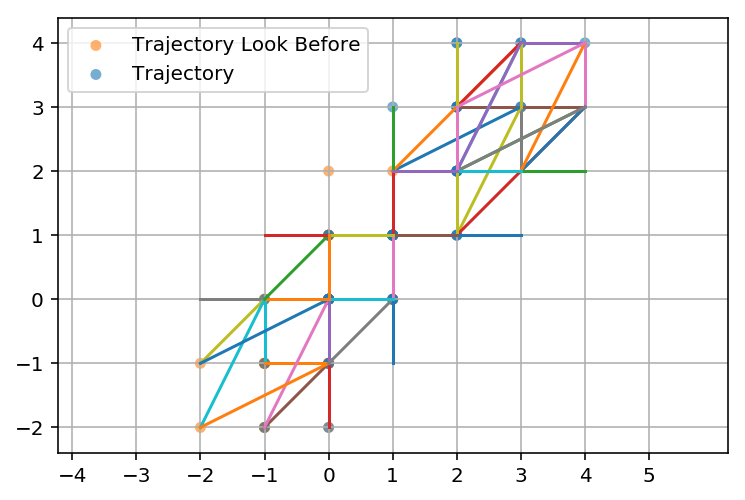

In [34]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()


axeX = []
axeY = []

axeX2 = []
axeY2 = []

for dicts in TrajectoryPointsLookBefore:
    for el in dicts:
        x, y = dicts[el]
        axeX2.append(x)
        axeY2.append(y)
    
for dicts in TrajectoryPoints:
    for el in dicts:
        x, y = dicts[el]
        axeX.append(x)
        axeY.append(y)       

#change these to adapt the grid :        
        
ax.set_xticks(np.arange(-6, 6, 1)) 
ax.set_yticks(np.arange(-6, 6, 1))        

for el in TrajectoryNoteEdges:
    for couple in el :
        x, y = couple
        line, = ax.plot(x, y)
    
ax.scatter(axeX2, axeY2, c='tab:orange', s=30, label='Trajectory Look Before', alpha=0.6, edgecolors='none')
ax.scatter(axeX, axeY, c='tab:blue', s=30, label='Trajectory', alpha=0.6, edgecolors='none')

ax.legend()
plt.grid()
plt.axis('equal')


plt.show()

Let's try graph libraries

In [35]:
import networkx as nx
G = nx.Graph()

In [36]:
def NotesToEdges(TrajectoryPoints, TrajectoryNoteEdges, Graph):
    listofPoints = []
    for i, dicts in enumerate(TrajectoryPoints):
        for el in dicts:
            Graph.add_node(dicts[el])
        for j in TrajectoryNoteEdges[i]:
            Graph.add_edge(j[0], j[1])
    return Graph

In [37]:
newGraph = NotesToEdges(TrajectoryPoints, TrajectoryNoteEdges, G)

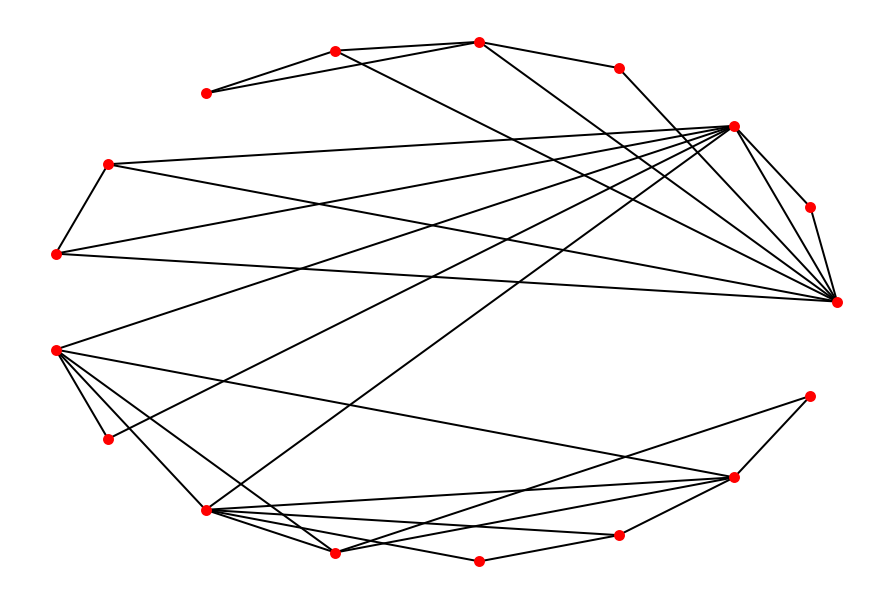

In [46]:
options = {
...     'node_color': 'red',
...     'node_size': 20,
...     'width': 1,
... }
nx.draw_circular(newGraph, **options)

Plotting with Delaunay Triangulations either computes a complete graph which is not hepful either it need more than three points to compute.

In [39]:
from scipy.spatial import Delaunay

def DelaunaySimplices(TrajectoryPoints):
    fig, ax = plt.subplots()
    plt.axis('equal')
    ax.grid(True) 
    for dicts in TrajectoryPoints:
        l = []
        for el in dicts:
            l.append(dicts[el])
        points = np.array(l)
        tri = Delaunay(points)
        plt.triplot(points[:,0], points[:,1], tri.simplices)
        plt.plot(points[:,0], points[:,1], 'o')
    plt.show()


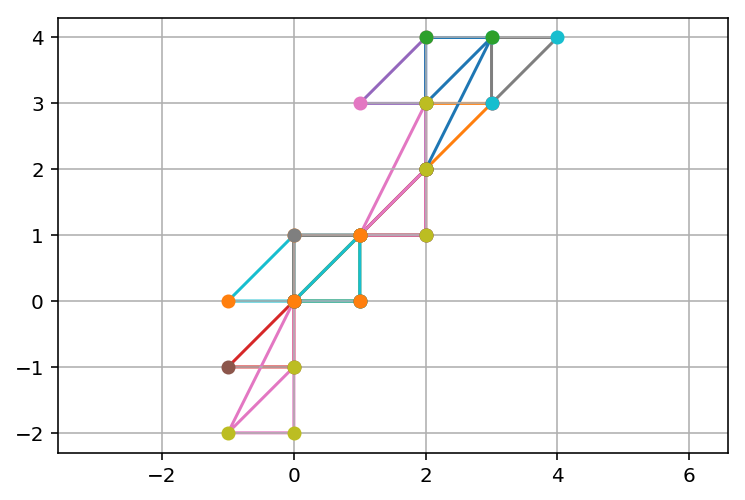

In [40]:
DelaunaySimplices(TrajectoryPoints)

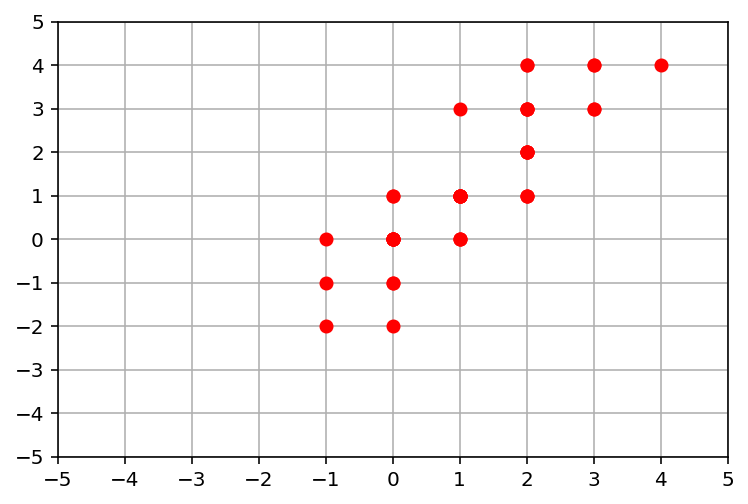

In [42]:
from matplotlib.animation import FuncAnimation
import numpy as np

fig, ax = plt.subplots()
ax.set_xticks(np.arange(-6, 6, 1)) 
ax.set_yticks(np.arange(-6, 6, 1))  
ax.grid()
xdata, ydata = [], []
N = len(axeX)
ln, = plt.plot([], [], 'ro')

def init():
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    return ln,

def update(frame):
    xdata.append(axeX[frame])
    ydata.append(axeY[frame])
    ln.set_data(xdata, ydata)
    return ln,

ani = FuncAnimation(fig, update, frames=np.arange(N),
                    init_func=init, blit=True)

plt.rc('animation', html='html5')
ani